In [1]:
import pandas as pd

Reads the individual-level BRFSS CSV (`df_individual_non_ecig_did.csv`) into `df`. This is the main analysis dataframe.

In [2]:
df = pd.read_csv("df_individual_non_ecig_did.csv")

In [3]:
df.head()

,id,_STATE,YEAR,treatment_year,is_non_ecig_smoker,weight,SEXVAR,INCOME3,_AGEG5YR
0,0,1.0,2009,NaN,0.0,758.095207,NaN,NaN,8.0
1,1,1.0,2009,NaN,1.0,306.537464,NaN,NaN,11.0
2,2,1.0,2009,NaN,1.0,188.928468,NaN,NaN,10.0
3,3,1.0,2009,NaN,0.0,552.713855,NaN,NaN,7.0
4,4,1.0,2009,NaN,0.0,55.189540,NaN,NaN,5.0


In [4]:
state_partisan = pd.read_csv("/home/parkermorrow/Downloads/state_partisan_composition_2009_2023.csv")
state_partisan.head()

,state,year,total_seats,senate_total,senate_dem,senate_rep,senate_other,house_total,house_dem,house_rep,house_other,leg_control,gov_party,state_control
0,Alabama,2009,140,35,19,13,0,105,62,43,0,NaN,NaN,NaN
1,Alaska,2009,60,20,10,10,0,40,18,22,0,NaN,NaN,NaN
2,Arizona,2009,90,30,12,18,0,60,25,35,0,NaN,NaN,NaN
3,Arkansas,2009,135,35,27,8,0,100,71,28,1,NaN,NaN,NaN
4,California,2009,120,40,26,14,0,80,51,29,0,NaN,NaN,NaN


- Calculates senate and house Republican seat shares.
- Constructs a combined `rep_control_index` (Republican seats / total seats).
- Builds a `rep_trifecta` flag (1 if both legislative chambers are Republican-majority and governor is R).
These create numeric partisan covariates for each state-year.

In [5]:
state_partisan['senate_rep_share'] = (
    state_partisan['senate_rep'] / state_partisan['senate_total']
)
state_partisan['house_rep_share'] = (
    state_partisan['house_rep'] / state_partisan['house_total']
)

# Optional: combined Republican control index (weighted by seats)
state_partisan['rep_control_index'] = (
    (state_partisan['senate_rep'] + state_partisan['house_rep']) /
    (state_partisan['senate_total'] + state_partisan['house_total'])
)

# Trifecta indicator
state_partisan['rep_trifecta'] = (
    (state_partisan['senate_rep_share'] > 0.5) &
    (state_partisan['house_rep_share'] > 0.5) &
    (state_partisan['gov_party'] == 'R')  # requires governor party
).astype(int)


Defines `state_fips_map`: mapping from numeric FIPS codes → state names. This is used to build reverse mappings for merges.

In [6]:
state_fips_map = {
    1: 'Alabama',
    2: 'Alaska',
    4: 'Arizona',
    5: 'Arkansas',
    6: 'California',
    8: 'Colorado',
    9: 'Connecticut',
    10: 'Delaware',
    11: 'District of Columbia',
    12: 'Florida',
    13: 'Georgia',
    15: 'Hawaii',
    16: 'Idaho',
    17: 'Illinois',
    18: 'Indiana',
    19: 'Iowa',
    20: 'Kansas',
    21: 'Kentucky',
    22: 'Louisiana',
    23: 'Maine',
    24: 'Maryland',
    25: 'Massachusetts',
    26: 'Michigan',
    27: 'Minnesota',
    28: 'Mississippi',
    29: 'Missouri',
    30: 'Montana',
    31: 'Nebraska',
    32: 'Nevada',
    33: 'New Hampshire',
    34: 'New Jersey',
    35: 'New Mexico',
    36: 'New York',
    37: 'North Carolina',
    38: 'North Dakota',
    39: 'Ohio',
    40: 'Oklahoma',
    41: 'Oregon',
    42: 'Pennsylvania',
    44: 'Rhode Island',
    45: 'South Carolina',
    46: 'South Dakota',
    47: 'Tennessee',
    48: 'Texas',
    49: 'Utah',
    50: 'Vermont',
    51: 'Virginia',
    53: 'Washington',
    54: 'West Virginia',
    55: 'Wisconsin',
    56: 'Wyoming'
}

# Reverse the mapping: state name → FIPS code
state_name_to_fips = {v: k for k, v in state_fips_map.items()}

# Map state names in your dataframe to FIPS codes
state_partisan['state_fips'] = state_partisan['state'].map(state_name_to_fips).astype(float)



In [7]:
state_partisan.head()

,state,year,total_seats,senate_total,senate_dem,senate_rep,senate_other,house_total,house_dem,house_rep,house_other,leg_control,gov_party,state_control,senate_rep_share,house_rep_share,rep_control_index,rep_trifecta,state_fips
0,Alabama,2009,140,35,19,13,0,105,62,43,0,NaN,NaN,NaN,0.371429,0.409524,0.400000,0,1.0
1,Alaska,2009,60,20,10,10,0,40,18,22,0,NaN,NaN,NaN,0.500000,0.550000,0.533333,0,2.0
2,Arizona,2009,90,30,12,18,0,60,25,35,0,NaN,NaN,NaN,0.600000,0.583333,0.588889,0,4.0
3,Arkansas,2009,135,35,27,8,0,100,71,28,1,NaN,NaN,NaN,0.228571,0.280000,0.266667,0,5.0
4,California,2009,120,40,26,14,0,80,51,29,0,NaN,NaN,NaN,0.350000,0.362500,0.358333,0,6.0


In [12]:
df.head()

,id,_STATE,YEAR,treatment_year,is_non_ecig_smoker,weight,SEXVAR,INCOME3,_AGEG5YR,cig_tax,leg_control,gov_party,state_control,senate_rep_share,house_rep_share,rep_control_index,rep_trifecta
0,0,1,2009,NaN,0.0,758.095207,NaN,NaN,8.0,42.5,Rep,Rep,Rep,0.714286,0.733333,0.728571,0.0
1,1,1,2009,NaN,1.0,306.537464,NaN,NaN,11.0,42.5,Rep,Rep,Rep,0.714286,0.733333,0.728571,0.0
2,2,1,2009,NaN,1.0,188.928468,NaN,NaN,10.0,42.5,Rep,Rep,Rep,0.714286,0.733333,0.728571,0.0
3,3,1,2009,NaN,0.0,552.713855,NaN,NaN,7.0,42.5,Rep,Rep,Rep,0.714286,0.733333,0.728571,0.0
4,4,1,2009,NaN,0.0,55.189540,NaN,NaN,5.0,42.5,Rep,Rep,Rep,0.714286,0.733333,0.728571,0.0


- Casts party-related columns to categorical to save memory and clarify types.
- Creates `gov_gop`, `leg_gop`, and `trifecta_gop` indicators derived from text fields.
- Ensures `rep_trifecta` is numeric (0/1).
These transformations standardize political covariates for analysis.

In [14]:
# categories → compact dtype
for col in ['gov_party','leg_control','state_control']:
    if col in df.columns:
        df[col] = df[col].astype('category')

# examples: GOP indicators
if 'gov_party' in df.columns:
    df['gov_gop'] = (df['gov_party'].astype(str).str.upper().str.startswith('R')).astype('uint8')

if 'leg_control' in df.columns:
    df['leg_gop'] = (df['leg_control'].astype(str).str.upper().str.contains('REP')).astype('uint8')

if 'state_control' in df.columns:
    df['trifecta_gop'] = (df['state_control'].astype(str).str.upper().str.contains('TRIFECTA') &
                                     df['gov_gop'].eq(1)).astype('uint8')

# rep_trifecta (if already 0/1 but object)
if 'rep_trifecta' in df.columns:
    df['rep_trifecta'] = pd.to_numeric(df['rep_trifecta'], errors='coerce').fillna(0).astype('uint8')


In [16]:
print(df.groupby('_STATE')['cig_tax_dollars'].mean().loc[[1,2,4,6]])
# Expect roughly:
# 1 (AL) ~ 0.675
# 2 (AK) ~ 2.00
# 4 (AZ) ~ 2.00
# 6 (CA) ~ 2.87


_STATE
1    0.447056
2    2.000000
4    2.000000
6    1.383522
Name: cig_tax_dollars, dtype: float64


Selects a compact set of variables (id, state, year, treatment-year, smoking indicator, weight, cig tax, rep index) and writes to `diff_with_cig_and_political.csv` for the DID workflow.

In [18]:
df[["id", "_STATE", "YEAR", "treatment_year", "is_non_ecig_smoker", "weight", "cig_tax_dollars", "rep_control_index"]].to_csv("diff_with_cig_and_political.csv", index=False)

In [19]:
%load_ext rpy2.ipython

/home/parkermorrow/.local/lib/python3.13/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "PWD" redefined by R and overriding existing variable. Current: "/home/parkermorrow", R: "/home/parkermorrow/Documents/grad_school/thesis/data/BRFSS/brfss_staggered"
  warnings.warn(
/home/parkermorrow/.local/lib/python3.13/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/usr/lib64/R/lib:/usr/lib/jvm/jre/lib/server", R: "/usr/lib64/R/lib:/usr/lib/jvm/jre/lib/server:/usr/lib64/R/lib:/usr/lib/jvm/jre/lib/server"
  warnings.warn(
/home/parkermorrow/.local/lib/python3.13/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "R_SESSION_TMPDIR" redefined by R and overriding existing variable. Current: "/tmp/RtmpWRISxi", R: "/tmp/Rtmpy8YnKw"
  warnings.warn(


R cell that reads `diff_with_cig_and_political.csv` and prints the head. Verifies the CSV is readable from R.

In [20]:
%%R
library(readr)
df <- read_csv("diff_with_cig_and_political.csv")
head(df)

Rows: 6774858 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (8): id, _STATE, YEAR, treatment_year, is_non_ecig_smoker, weight, cig_t...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 6 × 8
     id `_STATE`  YEAR treatment_year is_non_ecig_smoker weight cig_tax_dollars
  <dbl>    <dbl> <dbl>          <dbl>              <dbl>  <dbl>           <dbl>
1     0        1  2009             NA                  0  758.            0.425
2     1        1  2009             NA                  1  307.            0.425
3     2        1  2009             NA                  1  189.            0.425
4     3        1  2009             NA                  0  553.            0.425
5     4        1  2009             NA                  0   55.2           0.425
6     5        1  2009             NA                  0  343.    

- Builds `lean_2014` as each state's `rep_control_index` in 2014.
- Maps that 2014 value into all rows of `df_merged` as `rep_control_index_2014`.
- Bins the 2014 index into `party_lean` categories: 'Democratic', 'Mixed', 'Republican'.
This creates a time-invariant party-leaning group variable for subgroup analysis.

In [21]:
# Lock in partisan leaning as of 2014
lean_2014 = (
    state_partisan[state_partisan['year'] == 2014]
    .set_index('state_fips')['rep_control_index']
)

# Map each state’s 2014 leaning into all years
df['rep_control_index_2014'] = df['_STATE'].map(lean_2014)

df['party_lean'] = pd.cut(
    df['rep_control_index_2014'],
    bins=[-float('inf'), 0.4, 0.6, float('inf')],
    labels=['Democratic', 'Mixed', 'Republican']
)


Forms `df_out` with the selected variables plus frozen 2014 index and `party_lean`, then writes `diff_with_cig_and_political_party.csv` for downstream R analysis.

In [22]:
# after creating rep_control_index_2014 and party_lean
df_out = df[[
    "id", "_STATE", "YEAR", "treatment_year",
    "is_non_ecig_smoker", "weight",
    "cig_tax_dollars", "rep_control_index",
    "rep_control_index_2014", "party_lean"
]]

df_out.to_csv("diff_with_cig_and_political_party.csv", index=False)


- Reads `diff_with_cig_and_political_party.csv` into R and renames `_STATE` → `STATE`.
- Converts `party_lean` to factor.
- Replaces missing treatment years with `0L` (never-treated handled as control).
- Runs `att_gt` separately for Democratic-leaning and Republican-leaning state subsets:
  - Outcome: `is_non_ecig_smoker`
  - Unit id: `id`
  - Cohort: `treatment_year`
  - Controls: `~ 1` (no additional covariates)
  - Uses `notyettreated` control group, clustering by `STATE`, bootstrap inference (200 iterations).
- Aggregates to dynamic/event-study estimates with `aggte()` and prints summaries.
This block performs subgroup staggered DiD analyses by party lean.

In [23]:
%%R

library(readr)
library(dplyr)
library(did)

# Load the version with frozen 2014 lean
df <- read_csv("diff_with_cig_and_political_party.csv") %>%
  rename(STATE = `_STATE`)

# Convert to factor for clarity
df$party_lean <- as.factor(df$party_lean)

# Handle missing treatment years
df$treatment_year[is.na(df$treatment_year)] <- 0L

# Democratic states
att_dem <- att_gt(
  yname         = "is_non_ecig_smoker",
  tname         = "YEAR",
  idname        = "id",
  gname         = "treatment_year",
  xformla       = ~ 1,
  data          = df %>% filter(party_lean == "Democratic"),
  panel         = FALSE,
  weightsname   = "weight",
  clustervars   = "STATE",
  control_group = "notyettreated",
  anticipation  = 0,
  bstrap        = TRUE,
  biters        = 200
)

agg_dem <- aggte(att_dem, type="dynamic")
summary(agg_dem)

# Republican states
att_rep <- att_gt(
  yname         = "is_non_ecig_smoker",
  tname         = "YEAR",
  idname        = "id",
  gname         = "treatment_year",
  xformla       = ~ 1,
  data          = df %>% filter(party_lean == "Republican"),
  panel         = FALSE,
  weightsname   = "weight",
  clustervars   = "STATE",
  control_group = "notyettreated",
  anticipation  = 0,
  bstrap        = TRUE,
  biters        = 200
)

agg_rep <- aggte(att_rep, type="dynamic")
summary(agg_rep)


Rows: 6774858 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): party_lean
dbl (9): id, _STATE, YEAR, treatment_year, is_non_ecig_smoker, weight, cig_t...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Call:
aggte(MP = att_dem, type = "dynamic")

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


Overall summary of ATT's based on event-study/dynamic aggregation:  
    ATT    Std. Error     [ 95%  Conf. Int.] 
 -0.002        0.0035    -0.0089      0.0049 


Dynamic Effects:
 Event time Estimate Std. Error [95% Simult.  Conf. Band]  
         -9   0.0186     0.0046        0.0081      0.0291 *
         -8   0.0


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

In addition: Warning message:
In asMethod(object) :
  sparse->dense coercion: allocating vector of size 1.6 GiB


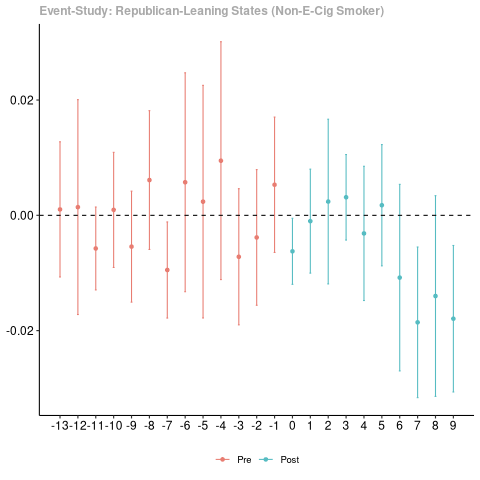

In [24]:
%%R

library(ggplot2)   # <-- add this

# Republican states
ggdid(agg_rep) + 
  ggtitle("Event-Study: Republican-Leaning States (Non-E-Cig Smoker)")


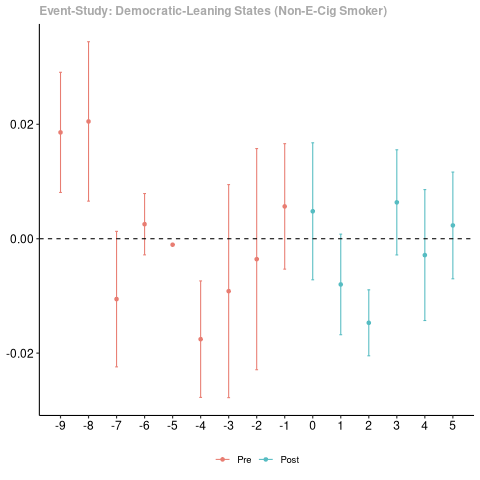

In [25]:
%%R

library(ggplot2)   # <-- add this

# Democratic states
ggdid(agg_dem) + 
  ggtitle("Event-Study: Democratic-Leaning States (Non-E-Cig Smoker)")

In [26]:
df = pd.read_csv("df_individual_did.csv")

In [27]:
df.head()

,id,_STATE,YEAR,treatment_year,is_any_smoker,weight,SEXVAR,INCOME3,_AGEG5YR
0,0,1.0,2009,NaN,0.0,758.095207,NaN,NaN,8.0
1,1,1.0,2009,NaN,1.0,306.537464,NaN,NaN,11.0
2,2,1.0,2009,NaN,1.0,188.928468,NaN,NaN,10.0
3,3,1.0,2009,NaN,0.0,552.713855,NaN,NaN,7.0
4,4,1.0,2009,NaN,0.0,55.189540,NaN,NaN,5.0


In [28]:
state_partisan = pd.read_csv("/home/parkermorrow/Downloads/state_partisan_composition_2009_2023.csv")
state_partisan.head()

,state,year,total_seats,senate_total,senate_dem,senate_rep,senate_other,house_total,house_dem,house_rep,house_other,leg_control,gov_party,state_control
0,Alabama,2009,140,35,19,13,0,105,62,43,0,NaN,NaN,NaN
1,Alaska,2009,60,20,10,10,0,40,18,22,0,NaN,NaN,NaN
2,Arizona,2009,90,30,12,18,0,60,25,35,0,NaN,NaN,NaN
3,Arkansas,2009,135,35,27,8,0,100,71,28,1,NaN,NaN,NaN
4,California,2009,120,40,26,14,0,80,51,29,0,NaN,NaN,NaN


In [29]:
state_fips_map = {
    1: 'Alabama', 2: 'Alaska', 4: 'Arizona', 5: 'Arkansas', 6: 'California',
    8: 'Colorado', 9: 'Connecticut', 10: 'Delaware', 11: 'District of Columbia',
    12: 'Florida', 13: 'Georgia', 15: 'Hawaii', 16: 'Idaho', 17: 'Illinois',
    18: 'Indiana', 19: 'Iowa', 20: 'Kansas', 21: 'Kentucky', 22: 'Louisiana',
    23: 'Maine', 24: 'Maryland', 25: 'Massachusetts', 26: 'Michigan',
    27: 'Minnesota', 28: 'Mississippi', 29: 'Missouri', 30: 'Montana',
    31: 'Nebraska', 32: 'Nevada', 33: 'New Hampshire', 34: 'New Jersey',
    35: 'New Mexico', 36: 'New York', 37: 'North Carolina', 38: 'North Dakota',
    39: 'Ohio', 40: 'Oklahoma', 41: 'Oregon', 42: 'Pennsylvania', 44: 'Rhode Island',
    45: 'South Carolina', 46: 'South Dakota', 47: 'Tennessee', 48: 'Texas',
    49: 'Utah', 50: 'Vermont', 51: 'Virginia', 53: 'Washington',
    54: 'West Virginia', 55: 'Wisconsin', 56: 'Wyoming'
}

# reverse mapping
state_name_to_fips = {v: k for k, v in state_fips_map.items()}


In [30]:
# Assuming your partisan file has a column "state" with state names
state_partisan['state_fips'] = state_partisan['state'].map(state_name_to_fips)


In [31]:
print(state_partisan.columns)


Index(['state', 'year', 'total_seats', 'senate_total', 'senate_dem',
       'senate_rep', 'senate_other', 'house_total', 'house_dem', 'house_rep',
       'house_other', 'leg_control', 'gov_party', 'state_control',
       'state_fips'],
      dtype='object')


In [32]:
state_partisan['rep_control_index'] = (
    (state_partisan['senate_rep'] + state_partisan['house_rep']) /
    (state_partisan['senate_total'] + state_partisan['house_total'])
)


In [33]:
df_merged = df.merge(
    state_partisan[['state_fips','year','rep_control_index']],
    left_on=['_STATE','YEAR'],
    right_on=['state_fips','year'],
    how='left'
)


In [34]:
lean_2014 = (
    state_partisan[state_partisan['year'] == 2014]
    .set_index('state_fips')['rep_control_index']
)

df_merged['rep_control_index_2014'] = df_merged['_STATE'].map(lean_2014)

df_merged['party_lean'] = pd.cut(
    df_merged['rep_control_index_2014'],
    bins=[-float('inf'), 0.4, 0.6, float('inf')],
    labels=['Democratic','Mixed','Republican']
)


In [35]:
df_out = df_merged[[
    "id","_STATE","YEAR","treatment_year",
    "is_any_smoker","weight",
    "rep_control_index_2014","party_lean"
]]
df_out.to_csv("diff_any_smoker_with_political.csv", index=False)


- Ensure consistent column names and datatypes before writing CSVs (e.g., `_STATE` numeric, `YEAR` numeric).
- Confirm `treatment_year` encoding for never-treated (either `NA`, `Inf`, or `0`) matches your DID function expectations.
- When subgrouping by `party_lean`, check group sizes and that each subgroup contains treated and not-yet-treated units to avoid singularities in `att_gt`.
- Keep `biters`/bootstrap iterations modest during debugging; increase for final results.

In [36]:
%%R

library(readr)
library(dplyr)
library(did)

# Load the version with frozen 2014 lean
df <- read_csv("diff_any_smoker_with_political.csv") %>%
  rename(STATE = `_STATE`)

# Convert to factor for clarity
df$party_lean <- as.factor(df$party_lean)

# Handle missing treatment years
df$treatment_year[is.na(df$treatment_year)] <- 0L

# Democratic states
att_dem <- att_gt(
  yname         = "is_any_smoker",
  tname         = "YEAR",
  idname        = "id",
  gname         = "treatment_year",
  xformla       = ~ 1,
  data          = df %>% filter(party_lean == "Democratic"),
  panel         = FALSE,
  weightsname   = "weight",
  clustervars   = "STATE",
  control_group = "notyettreated",
  anticipation  = 0,
  bstrap        = TRUE,
  biters        = 200
)

agg_dem <- aggte(att_dem, type="dynamic")
summary(agg_dem)

# Republican states
att_rep <- att_gt(
  yname         = "is_any_smoker",
  tname         = "YEAR",
  idname        = "id",
  gname         = "treatment_year",
  xformla       = ~ 1,
  data          = df %>% filter(party_lean == "Republican"),
  panel         = FALSE,
  weightsname   = "weight",
  clustervars   = "STATE",
  control_group = "notyettreated",
  anticipation  = 0,
  bstrap        = TRUE,
  biters        = 200
)

agg_rep <- aggte(att_rep, type="dynamic")
summary(agg_rep)


Rows: 6774858 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): party_lean
dbl (7): id, _STATE, YEAR, treatment_year, is_any_smoker, weight, rep_contro...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Call:
aggte(MP = att_dem, type = "dynamic")

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


Overall summary of ATT's based on event-study/dynamic aggregation:  
    ATT    Std. Error     [ 95%  Conf. Int.] 
 -7e-04        0.0035    -0.0076      0.0062 


Dynamic Effects:
 Event time Estimate Std. Error [95% Simult.  Conf. Band]  
         -9   0.0186     0.0046        0.0087      0.0285 *
         -8   0.02

In addition: Warning message:
In asMethod(object) :
  sparse->dense coercion: allocating vector of size 1.6 GiB


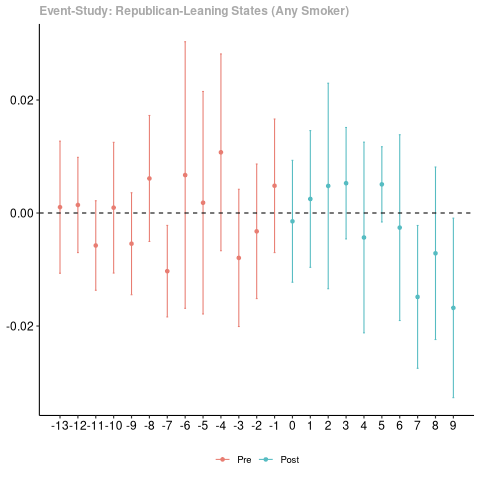

In [37]:
%%R

ggdid(agg_rep) + ggtitle("Event-Study: Republican-Leaning States (Any Smoker)")

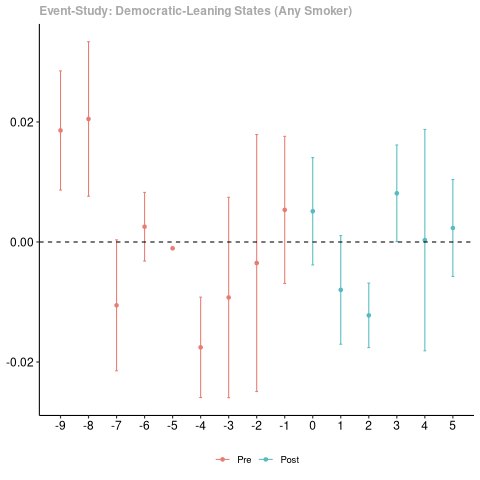

In [38]:
%%R

ggdid(agg_dem) + ggtitle("Event-Study: Democratic-Leaning States (Any Smoker)")